In [11]:
import random

import numpy as np
import networkx as nx
from scipy import sparse
from scipy.interpolate import CubicSpline
from scipy import integrate
from scipy import optimize
from warnings import warn
from math import floor
import numdifftools as ndt


import sys
import numpy as np
import rescomp as rc
import networkx as nx
from scipy import sparse
from ipyparallel import Client
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import sklearn.gaussian_process as GP
from scipy.interpolate import CubicSpline
from bayes_opt import BayesianOptimization as bopt

import warnings
warnings.filterwarnings("ignore")



### 1. Rescomp

In [12]:
class ResComp2:
    """ Reservoir Computer Class

        Initialization options:
        -----------------------
        0 arguments: Initializes the reservoir as a random graph with all other
                     datamembers determined by keyword arguments
        1 argument:  Assumes argument to be an adjacency matrix. Makes the internal
                     reservoir equal to the argement. Matrix properties take precedence
                     over keyword arguments. i.e. If `A` is dense, `ResComp(A, sparse_res=True)`
                     will have a dense reservoir matrix.

        Parameters:
        -----------
        A (nxn ndarray): Adjacency matrix for reservoir network.

        Keyword Arguments:
        res_sz:          (Int) Number of nodes in reservoir
        signal_dim:      (Int) Dimension of the training signal

        mean_degree:     (Float) Average number of edges per node in the reservoir network
                                 Defaults to 2.0
        spect_rad:       (Float) Desired reservoir spectral radius
                                 Defaults to 0.9
        sigma:           (Float) Reservoir ode hyperparameter
                                 Defaults to 0.1
        gamma:           (Float) Reservoir ode hyperparameter
                                 Defaults to 1.0
        ridge_alpha:     (Float) Regularization parameter for the ridge regression solver
                                 Defaults to 1e-4
        activ_f:         (Function) Activation function for reservoir nodes. Used in ODE
                                 Defaults to `numpy.tanh`
        sparse_res:      (Bool) Chose to use sparse matrixes or dense matrixes
                                 Defaults to True
        uniform_weights: (Bool) Choose between uniform or random edge weights
                                 Defaults to True
        max_weight:      (Float) Maximim edge weight if uniform_weights=False
                                 Defaults to 2.0
        min_weight:      (Float) Minimum edge weight if uniform_weights=False.
                                 Defaults to 0.0
        batchsize:       (Int) Maximum length of training batch.
                                 Defaults to 2000
        map_initial      (str) How to pick an initial reservoir node condition. One of
                         ['fixed point', 'relax', activ_f', 'psuedoinverse', 'random', 'W_in'].
                         See documentation of self.initial_condition for details
                                 Defaults to "relax"

        ** Note that adjacency matrix weights are scaled after initialization
        to achive desired spectral radius **
    """
    def __init__(self,
                 *args,
                 res_sz=100,
                 activ_f=np.tanh,
                 mean_degree=2.0,
                 ridge_alpha=1e-4,
                 spect_rad=.9,
                 sparse_res=True,
                 sigma=0.1,
                 uniform_weights=True,
                 gamma=1.,
                 signal_dim=3,
                 max_weight=2,
                 min_weight=0,
                 batchsize=2000,
                 map_initial="relax"
                ):
        # Set model data members
        self.signal_dim  = signal_dim
        self.gamma       = gamma
        self.sigma       = sigma
        self.activ_f     = activ_f
        self.ridge_alpha = ridge_alpha
        self.sparse_res  = sparse_res
        self.spect_rad   = spect_rad
        self.mean_degree = mean_degree
        self.res_sz      = res_sz
        self.min_weight  = min_weight
        self.max_weight  = max_weight
        self.uniform_weights = uniform_weights
        self.batchsize = batchsize
        self.is_trained  = False
        self.map_initial = map_initial

        # Make reservoir adjacency matrix based on number of arguments to __init__
        # No non-keyword arguments:
        if len(args) == 0:
            # Create random graph adjacency matrix
            n = self.res_sz
            p = self.mean_degree / n
            A = self.random_graph(n, p)
            if not sparse_res:
                # Convert to dense
                A = A.toarray()
            if self.uniform_weights:
                # Set non zero entries to 1.0 (Make edge weights uniform)
                A = (A != 0).astype(float)
            # Multiply matrix by a constant to achive the desired spectral radius
            self.res = A
            self.scale_spect_rad()
        # One non keyword argument:
        elif len(args) == 1:
            # Passing in a matrix takes precidence over all other keyword args.
            A = args[0]
            # Input validation
            try:
                assert len(A.shape) == 2
            except AttributeError:
                raise ValueError("ResComp mut be initialized with a numpy array or sparse scipy array")
            except AssertionError:
                raise ValueError("ResComp must be initialized with a 2-d array")
            self.res = A
            self.sparse_res = sparse.issparse(A)
        # Adjust data members to match reservoir structure
        self.set_res_data_members()

    def set_res_data_members(self):
        """ Ensure that the datamembers match the composition of the reservoir """
        self.res_sz = self.res.shape[0]
        self.r0 = 2*np.random.rand(self.res_sz) - 1.0
        self.mean_degree = np.sum(self.res != 0)/(self.res_sz)
        # W_in initialized from a uniform distribution on [-1, 1]
        self.W_in = 2*(np.random.rand(self.res_sz, self.signal_dim) - 0.5)
        # W_out has not yet been computed
        self.W_out = np.zeros((self.signal_dim, self.res_sz))
        # Arrays to store pieces of the Tikhonov regression solution
        self.Rhat = np.zeros((self.res_sz, self.res_sz))
        self.Yhat = np.zeros((self.signal_dim, self.res_sz))
        self.spect_rad = self._spectral_rad(self.res)
        # Determine the max and min edge weights
        if self.sparse_res:
            edge_weights = list(sparse.dok_matrix(self.res).values())
        else:
            edge_weights = self.res[self.res != 0]
        if len(edge_weights) == 0:
            self.max_weight = 0
            self.min_weight = 0
        else:
            self.max_weight = np.max(edge_weights)
            self.min_weight = np.min(edge_weights)
        self.uniform_weights = (self.max_weight - self.min_weight) < 1e-12

    def _spectral_rad(self, A):
        """ Compute spectral radius via max radius of the strongly connected components """
        
        ### TEST!!!
        print("SETTING IT")

        g = nx.DiGraph(A.T)
        if self.sparse_res:
            A = A.copy().todok()
        scc = nx.strongly_connected_components(g)
        rad = 0
        for cmp in scc:
            # If the component is one node, spectral radius is the edge weight of it's self loop
            if len(cmp) == 1:
                i = cmp.pop()
                max_eig = A[i,i]
            else:
                # Compute spectral radius of strongly connected components
                adj = nx.adjacency_matrix(nx.subgraph(g,cmp))
                max_eig = np.max(np.abs(np.linalg.eigvals(adj.T.toarray())))
            if max_eig > rad:
                rad = max_eig
        return rad

    def scale_spect_rad(self):
        """ Scales the spectral radius of the reservoir so that
            _spectral_rad(self.res) = self.spect_rad
        """

        ### TEST!!!
        print("SCALING IT")

        curr_rad = self._spectral_rad(self.res)
        if not np.isclose(curr_rad,0, 1e-8):
            self.res *= self.spect_rad/curr_rad
        else:
            warn("Spectral radius of reservoir is close to zero. Edge weights will not be scaled")
        # end
        # Convert to csr if sparse
        if sparse.issparse(self.res):
            self.res = self.res.tocsr()
    #-------------------------------------
    # ODEs governing reervoir node states
    #-------------------------------------
    def res_ode(self, t, r, u):
        """ ODE to drive the reservoir node states with u(t) """
        return self.gamma * (-1 * r + self.activ_f(self.res @ r + self.sigma * self.W_in @ u(t)))

    def trained_res_ode(self, t, r):
        """ Reservoir prediction ode. Assumes precomputed W_out """
        return self.gamma*(-1*r + self.activ_f(self.res @ r + self.sigma * self.W_in @ (self.W_out @ r)))

    def jacobian(self, t, r, u, trained=True):
        """ The jacobian matrix of the untrained reservoir ode w.r.t. r. That is, if
                dr/dt = F(t, r, u)
                Jij = dF_i/dr_j
            Parameters:
                t (float): Time value
                r (ndarray): Array of length `self.res_sz` reservoir node state
                u (callable): function that accepts `t` and returns an ndarray of length `self.signal_dim`
            Returns:
                Jnum (callable): Accepts a node state r (ndarray of length `self.res_sz') and returns a
                (`self.res_sz` x `self.res_sz`) array of partial derivatives (Computed numerically
                with finite differences). See `numdifftools.Jacobian`
        """
        if trained:
            f = lambda r : self.trained_res_ode(t, r, u)
        else:
            f = lambda r : self.res_ode(t, r, u)
        Jnum = ndt.Jacobian(f)
        return Jnum

    def initial_condition(self, u0):
        """ Function to map external system initial conditions to reservoir initial conditions
            Options are set by changing the value of self.map_initial. The options work as follows:
            "fixed point"
                This sets the initial reservoir node condition to the fixed point induced by the initial
                state of the training signal. Theoretically, this should eliminate transience in the node state.
                The nonlinear root finder is sensitive to initial conditions and may not converge.
            "relax"
                This method allows the reservoir nodes to relax into a steady state corresponding to `u0`.
                This typically conincided with the fixed point above but unlike the nonlinear solver, this method
                always converged.
            "activ_f"
                This sets the reservoir initial condition to r0 = activ_f(sigma * W_in @ u0). Incidentally, should send
                the reservoir initial condition close to the attracting fixed points of the system
            "activ_f_unscaled"
                This sets the reservoir initial condition to r0 = activ_f(sigma * W_in @ u0). Included for legacy reasons.
            "pseudoinverse"
                Only for use after training. This uses the pseudoinverse of W_out to compute the initial node
                state from an inital condition from the learned system
            "random"
                Sets node states at random. Draws from [-1,1] for tanh and sin activation functions and [0, 1]
                otherwise.
        """
        if self.map_initial == "fixed point":
            u = lambda x: u0
            fixed_res_ode = lambda r: self.res_ode(0, r, u)
            r0 = optimize.fsolve(fixed_res_ode, np.ones(self.res_sz))
        elif self.map_initial == "relax":
            u = lambda x: u0
            fixed_res_ode = lambda r: self.res_ode(0, r, u)
            initial = 2*np.random.rand(self.res_sz) - 1
            tvals = np.linspace(0, 10000, 100)
            R = integrate.odeint(self.res_ode, initial, tvals, tfirst=True, args=(u,))
            r0 = R[-1,:]
            err = np.max(np.abs(r0 - R[-2, :]))
            if  err > 1e-12:
                warn(f"Reservoir fixed point failed to converge. ||r_n - r_(n+1)|| = {err}")
        elif self.map_initial == "activ_f":
            r0 = self.activ_f(self.W_in @ (self.sigma * u0))
        elif self.map_initial == "activ_f_unscaled":
            r0 = self.activ_f(self.W_in @ u0)
        elif self.map_initial == "pseudoinverse":
            if not self.is_trained:
                raise ValueError("Cannot use `map_initial='pseudoinverse'` because the reservoir is untrained")
            W = self.W_out
            r0 = np.linalg.inv(W.T @ W) @ (W.T @ u0)
        elif self.map_initial == "random":
            if (self.activ_f == np.tanh) or (self.activ_f == np.sin):
                r0 = 2*np.random.rand(self.res_sz) - 1
            else:
                r0 = np.random.rand(self.res_sz)
        elif self.map_initial == "W_in":
            r0 = self.W_in @ u0
        else:
            raise ValueError(f"The value of `map_initial`='{self.map_initial}'. It must be in ['fixed point', 'relax', activ_f', 'psuedoinverse', 'random', 'W_in'], or it must be callable.")
        return r0

    #-------------------------------------
    # Default reservoir topology
    #-------------------------------------
    def weights(self,n):
        """ Weights for internal reservoir"""
        if self.uniform_weights:
            return np.ones(n)
        else:
            return (self.max_weight-self.min_weight)*np.random.rand(n) + self.min_weight

    def random_graph(self, n, p):
        """ Create the sparse adj matrix of a random directed graph
            on n nodes with probability of any link equal to p
        """
        A = sparse.random(n,n, density=p, dtype=float, format="lil", data_rvs=self.weights)
        # Remove self edges
        for i in range(n):
             A[i,i] = 0.0
        # Add one loop to ensure positive spectral radius
        if n > 1:
            A[0, 1] = self.weights(1)
            A[1, 0] = self.weights(1)
        return A

    #---------------------------
    # Train and Predict
    #---------------------------
    def train(self, t, U, window=None, overlap=0):
        """ Train the reservoir computer so that it can replicate the data in U.

            Paramters
            ---------
            t (1-d array or list of 1-d arrays): Array of m equally spaced time values corresponding to signal U.
            U (array or list of arrays): Input signal array (m x self.signal_dim) where the ith row corresponds to the
                signal value at time t[i]
            window (float): If window is not `None` the reservoir computer will subdivide the input signal
                into blocks where each block corresponds to `window` seconds of time.
                Defaults to None
            overlap (float): Must be less than one and greater or equal to zero. If greater than zero, this
                will cause subdivided input signal blocks to overlap. The `overlap` variable specifies the
                percent that each signal window overlaps the previous signal window
                Defaults to 0.0
        """
        if isinstance(U, list) and isinstance(t, list):
            for time, signal in zip(t, U):
                idxs = self._partition(time, window, overlap=overlap)
                for start, end in idxs:
                    ti = time[start:end]
                    Ui = signal[start:end, :]
                    self.update_tikhanov_factors(ti, Ui)
        else:
            idxs = self._partition(t, window, overlap=overlap)
            for start, end in idxs:
                ti = t[start:end]
                Ui = U[start:end, :]
                self.update_tikhanov_factors(ti, Ui)
        self.W_out = self.solve_wout()
        self.is_trained = True


    def internal_state_response(self, t, U, r0):
        """ Drive the reservoir node states with the signal U
            Parameters
            t (1 dim array): array of time values
            U (array): for each i, U[i, :] produces the state of the target system
                at time t[i]
            r0 (array): Initial condition of reservoir nodes

        """
        u = CubicSpline(t, U)
        states = integrate.odeint(self.res_ode, r0, t, tfirst=True, args=(u,))
        return states

    def update_tikhanov_factors(self, t, U):
        """ Drive the reservoir with the u and collect state information into
            self.Rhat and self.Yhat
            Parameters
            t (1 dim array): array of time values
            U (array): for each i, U[i, :] produces the state of the target system
                at time t[i]
        """
        # The i + batchsize + 1 ending adds one timestep of overlap to provide
        # the initial condition for the next batch. Overlap is removed after
        # the internal states are generated
        idxs = [(i, i + self.batchsize + 1) for i in range(0, len(t), self.batchsize)]
        #Prevent length-1 segment at the end
        if len(t)-idxs[-1][0] <= 1:
            idxs = idxs[:-1]
            idxs[-1] = (idxs[-1][0], len(t))
        # Set initial condition for reservoir nodes
        r0 = self.initial_condition(U[0, :])
        for start, end in idxs:
            ti = t[start:end]
            Ui = U[start:end, :]
            states = self.internal_state_response(ti, Ui, r0)
            # Get next initial condition and trim overlap
            states, r0 = states[:-1, :], states[-1, :]
            # Update Rhat and Yhat
            self.Rhat += states.T @ states
            self.Yhat += Ui[:-1, :].T @ states
        self.r0 = r0

    def solve_wout(self):
        """ Solve the Tikhonov regularized least squares problem (Ridge regression)
            for W_out (The readout mapping)
        """
        #Check that Rhat and Yhat aren't overflowed
        if not (np.all(np.isfinite(self.Rhat)) and np.all(np.isfinite(self.Yhat))):
            raise OverflowError('overflow occurred while computing regression')
        try:
            W_out = self.Yhat @ np.linalg.inv(self.Rhat + self.ridge_alpha * np.eye(self.res_sz))
        except np.linalg.LinAlgError:
            #Try the pseudoinverse instead
            W_out = self.Yhat @ np.linalg.pinv(self.Rhat + self.ridge_alpha * np.eye(self.res_sz))
        return W_out

    def predict(self, t, u0=None, r0=None, return_states=False):
        """ Predict the evolution of the learned system.
        
            Parameters
            ----------
            t (ndarray): One dimensional array of time values
            u0 (ndarray): One dimensional array of initial conditions corresponding to the learned system
            r0 (ndarray): One dimensional array of initial conditions corresponding to reservoir nodes
            return_states (bool): Option to return states of the reservoir nodes in addition to prediction
            
            Returns
            -------
            pred (ndarray): Array with dimensions len(t) x self.signal_dim. Pred[i,:] is a prediction of 
                u(t[i]) where u is the learned signal
            states (ndarray): Only returned if return_states is True. Reservoir node states. states[i] = r(t[i]) 
                where r is the reservoir node states
                
            Usage
            -----
            Typically, predict is passed the state of the reservoir nodes r0 at the end of training. EX.
                rcomp = rc.ResComp
                rcomp.train(train_t, U) # Automatically stores the last node state
                r0 = rcomp.r0
                prediction = rcomp.predict(test_t, r0=r0)
            If you want to see how the reservoir computer predicts the trained system will respond to an 
            arbitrary initial condition try:
                u0 = np.array([1.0, 1.0, 1.0])  
                prediction = rcomp.predict(test_t, u0=u0)
            Unless specialized training methods are used the above is likely to fail.
        """
        # Determine initial condition
        if (u0 is not None):
            r0 = self.initial_condition(u0)
        elif r0 is None :
            r0 = self.r0
        if not self.is_trained:
            raise Exception("Reservoir is untrained")
        states = integrate.odeint(self.trained_res_ode, r0, t, tfirst=True)
        pred = self.W_out @ states.T
        # Return internal states as well as predicition or not
        if return_states:
            return pred.T, states
        return pred.T

    def _partition(self, t, time_window, overlap=0.0):
        """ Partition `t` into subarrays that each include `time_window` seconds. The variable
            `overlap` determines what percent of each sub-array overlaps the previous sub-array.
            The last subarray may not contain a full time window.
        """
        if (overlap >= 1) or (overlap < 0.0):
            raise ValueError("Overlap argument must be greater than or equal to zero and less than one")
        if time_window is None:
            return ((0, -1),)
        idxs = ()
        start = 0
        tmax = t[start] + time_window
        for i,time in enumerate(t):
            while time > tmax:
                end = i
                if end - start == 1:
                    warn("rescomp.ResComp._partition partitioning time array into single entry arrays. Consider increasing time window")
                idxs += ((start,end),)
                diff = floor((end - start) * (1.0 - overlap))
                start += max(diff, 1)
                tmax = t[start] + time_window
        if len(t)-start > 1:
            idxs += ((start, len(t)),)
        return idxs

### 2. Helpers

In [13]:
def valid_prediction_index(err, tol):
    """First index i where err[i] > tol. err is assumed to be 1D and tol is a float. If err is never greater than tol, then len(err) is returned."""
    mask = np.logical_or(err > tol, ~np.isfinite(err))
    if np.any(mask):
        return np.argmax(mask)
    return len(err)

def wa_vptime(ts, Uts, pre, vpttol=0.5):
    """
    Valid prediction time for a specific instance.
    """
    err = np.linalg.norm((Uts-pre), axis=1, ord=2)
    idx = valid_prediction_index(err, vpttol)
    if idx == 0:
        vptime = 0.
    else:
        vptime = ts[idx-1] - ts[0]

    return vptime

In [14]:
# GET TRAINING AND TESTING SIGNALS
t, U = rc.orbit('lorenz', duration=150)
u = CubicSpline(t, U)
tr = t[:4000]
Utr = u(t[:4000])
ts = t[4000:]
Uts = u(t[4000:])  

In [15]:
def setres(my_dict, auto=False, map=False, scale=False, A=None):
    # OTHER PARAMS
    n = 500
    combo = 124750 ### ----- comb(500,2)
    c = 4

    # LOAD FROM DICTIONARY
    rho = my_dict['rho']
    pthin = my_dict['pthin']
    a = my_dict['a']
    g = my_dict['g']
    s = my_dict['s']

    if auto:
        res = rc.ResComp(res_sz=n, mean_degree=4*(1-pthin), spect_rad=rho, sigma=s, gamma=g, ridge_alpha=a)
    else:
        if A is None:
            # CREATE GRAPH
            A = nx.erdos_renyi_graph(n,c*(1-pthin)/(n-1),directed=True)
            A = sparse.dok_matrix(nx.adj_matrix(A).T)        

        if scale: # SCALE AND MAKE RESERVOIR
            scale_denom = np.abs(sparse.linalg.eigs(A.astype(float),k=1)[0][0])
            if scale_denom > 1e-8:
                B = A*(rho/scale_denom)
                A = B.copy()

        try:
            res = ResComp2(A.tocoo(), spect_rad=rho, sigma=s, gamma=g, ridge_alpha=a)
        except:
            return
    res.train(tr, Utr)
    print('training')

    if map:
        res.map_initial = 'activ_f'

    return res, A

In [16]:
def plotit(Upred, res_states, pred_states, title=''):
    plt.figure(figsize=(12,3))
    
    # PLOT PREDICTION
    plt.subplot(131)
    plt.plot(ts[:1000], Uts[:1000,0], c='C0')
    plt.plot(ts[:1000], Uts[:1000,1], c='C0')
    plt.plot(ts[:1000], Uts[:1000,2], c='C0')
    plt.plot(ts[:1000], Upred[:1000,0], c='C1')
    plt.plot(ts[:1000], Upred[:1000,1], c='C1')
    plt.plot(ts[:1000], Upred[:1000,2], c='C1')
    plt.title('prediction for t > T')

    # PLOT RESPONSES [0,T]
    plt.subplot(132)
    for i,c in enumerate(plt.get_cmap('viridis')(np.linspace(0,0.8,50))):
        plt.plot(tr[:1000], res_states[:1000, [i]], '-', color=c, alpha=0.8)
    # plt.ylim(-1.1,1.1)
    r0 = res_states[0]
    plt.scatter([tr[0]]*len(r0[:50]), r0[:50], c='k')
    plt.title(f'responses for t in [0,T]\n{np.round(np.min(res_states), 4)} to {np.round(np.max(res_states),4)}')
    
    # PLOT RESPONSES > T
    plt.subplot(133)
    for i,c in enumerate(plt.get_cmap('viridis')(np.linspace(0,0.8,50))):
        plt.plot(ts[:1000], pred_states[:1000, [i]], '-', color=c, alpha=0.8)
    # plt.ylim(-1.1,1.1)
    plt.title(f'responses for t > T\n{np.round(np.min(pred_states), 4)} to {np.round(np.max(pred_states),4)}')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [17]:
def test_it(res, title=''):
    # GET RESPONSES
    r0 = res.initial_condition(Utr[0])
    res_states = res.internal_state_response(tr, Utr, r0)

    # GET VPT
    Upred, pred_states = res.predict(ts, r0=res.r0, return_states=True) # --- same as not specifying that r0=res.r0
    vpt = wa_vptime(ts[:-2], Uts[:-2], Upred[2:], vpttol=5)

    # PLOT
    plotit(Upred, res_states, pred_states, title+f'\nvpt = {vpt}')

In [18]:
rho_50p0_pthin_0p9 = {'rho': 50, 'pthin': 0.9, 'VPT': 2.2568333333333346, 'a': 0.0038150056733363027, 'g': 16.470072504771654, 's': 0.24581307008326905}

def seedit(my_dict=rho_50p0_pthin_0p9):
    res1, A = setres(my_dict, scale=False, map=False)
    print(res1.spect_rad)
    test_it(res1, title='No Scaling')

    res1, B = setres(my_dict, scale=True, A=A, map=False)
    print(res1.spect_rad)
    test_it(res1, title='Scaling manually')

    res2, A = setres(my_dict, auto=True)
    print(res2.spect_rad)
    test_it(res1, title='Auto scale')

In [19]:

rho_1p1_pthin_0p0 = {'rho': 1.1, 'pthin': 0.0, 'VPT': 3.629333333333335, 'a': 0.00827891588205206, 'g': 8.73362404864725, 's': 0.05446701798507083}

### 3. Testing

SETTING IT
1.0


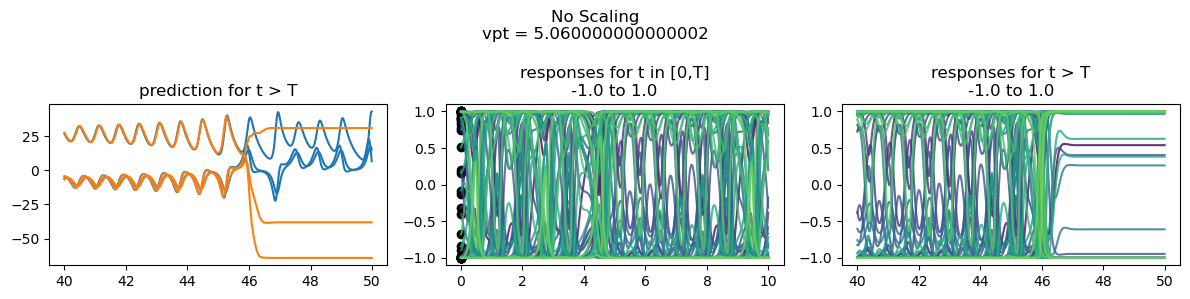

SETTING IT
50.00000000000004


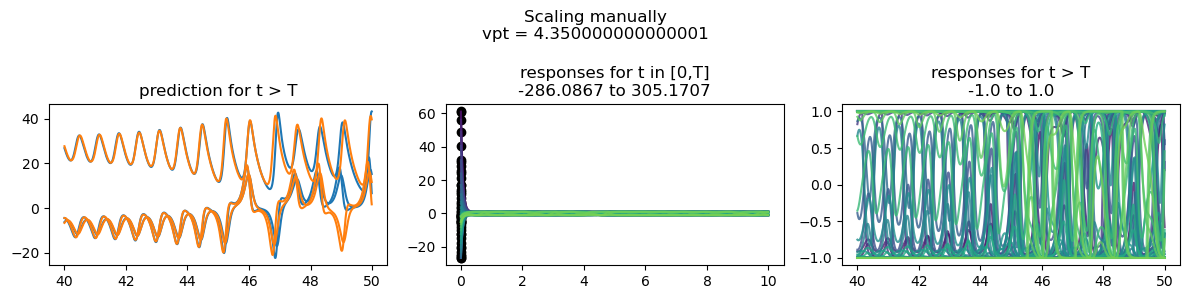

50.00000000000001


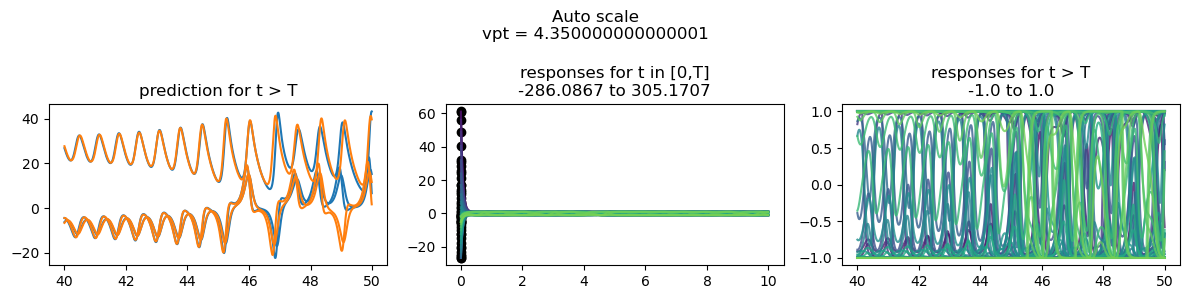

In [20]:
random.seed(10)
seedit()

SETTING IT


0


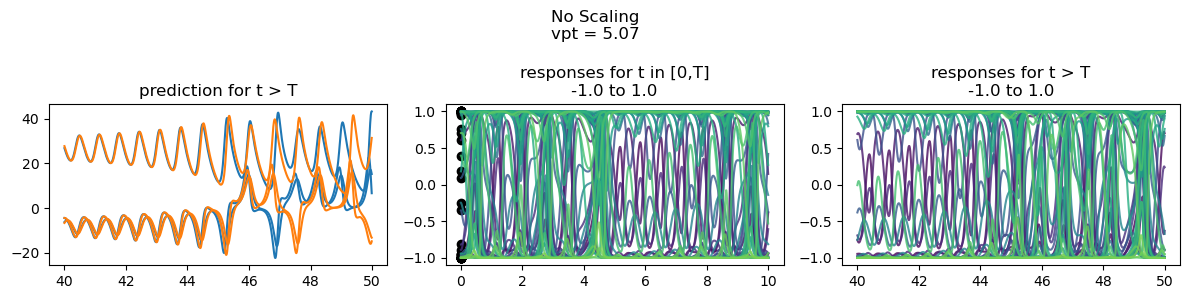

SETTING IT
0


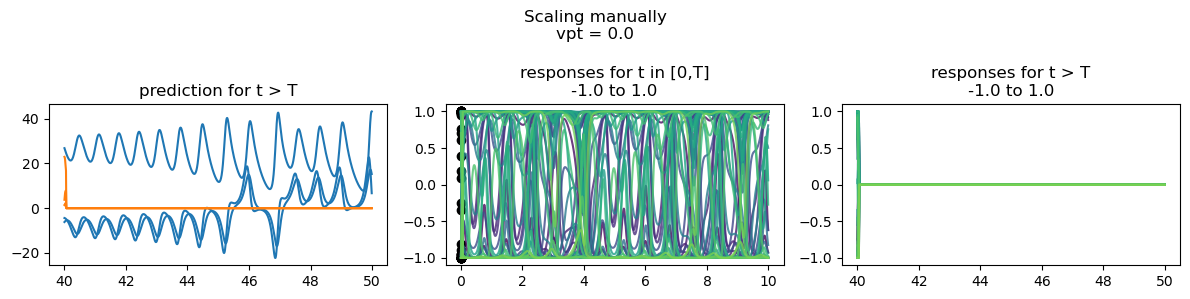

50.00000000000001


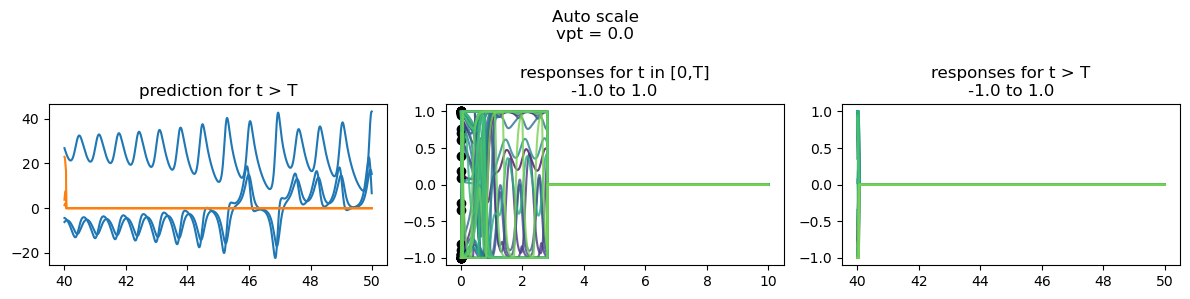

In [21]:
random.seed(1)
seedit()

SETTING IT
0


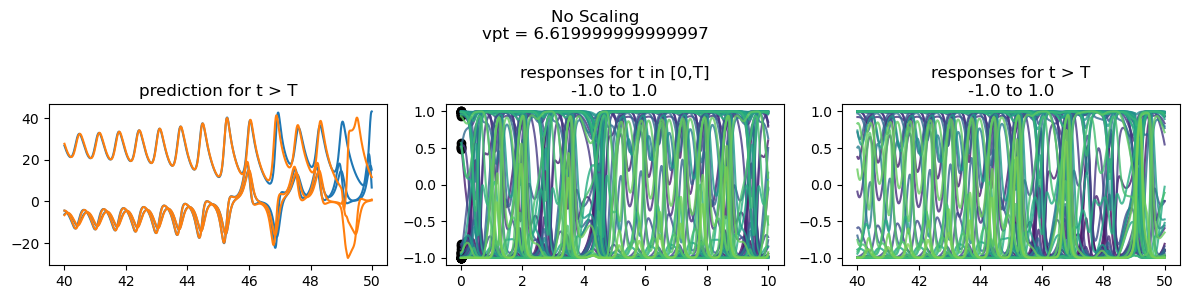

SETTING IT
0


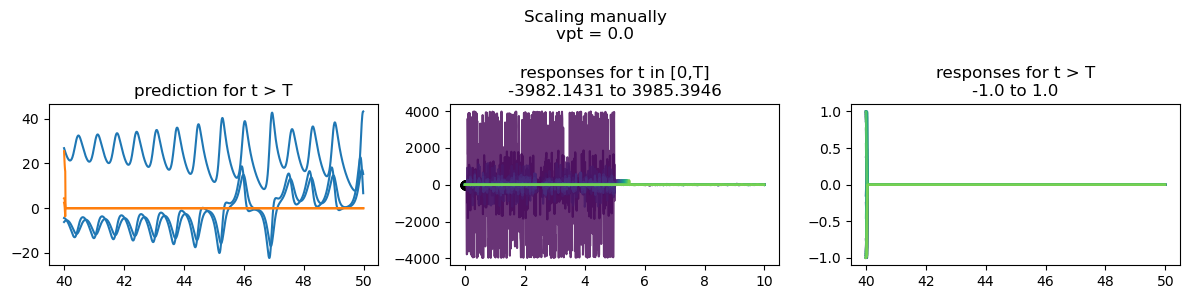

50.00000000000001


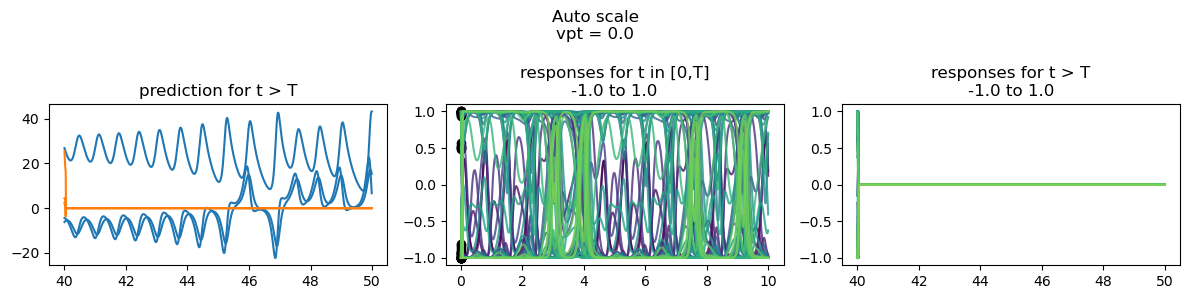

In [22]:
random.seed(2)
seedit()

SETTING IT


0


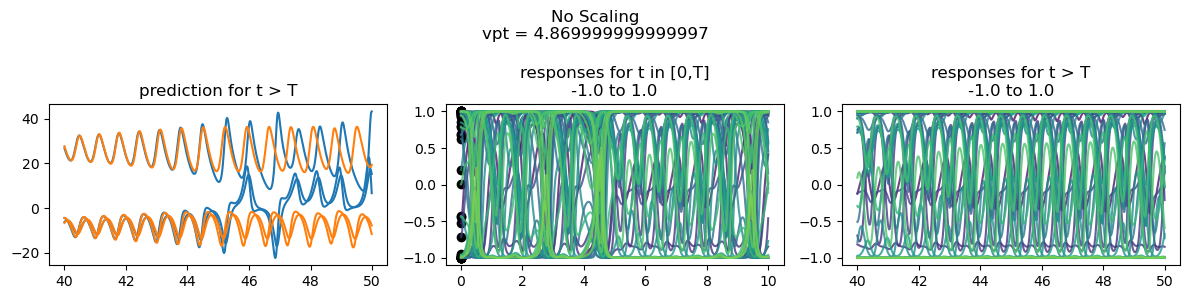

SETTING IT
0


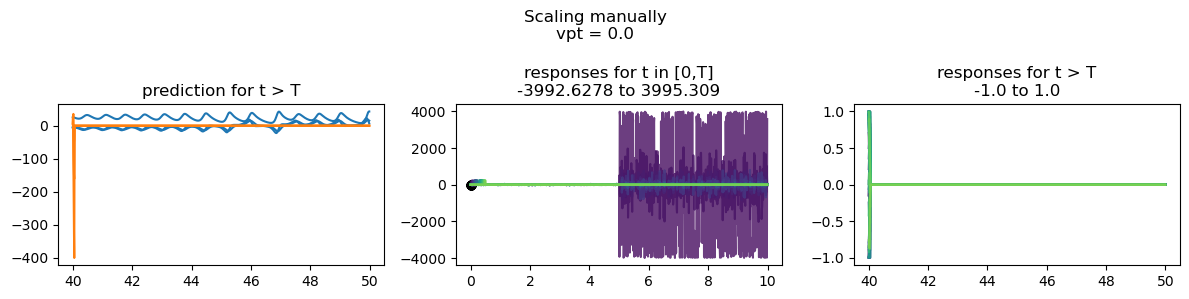

50.00000000000001


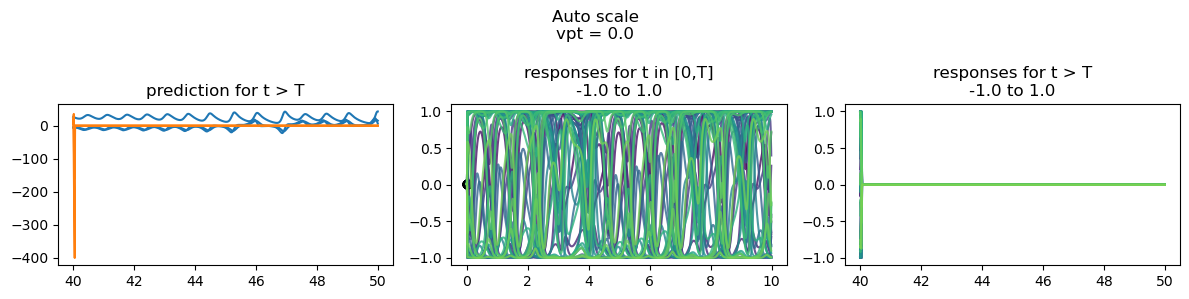

In [23]:
random.seed(3)
seedit()